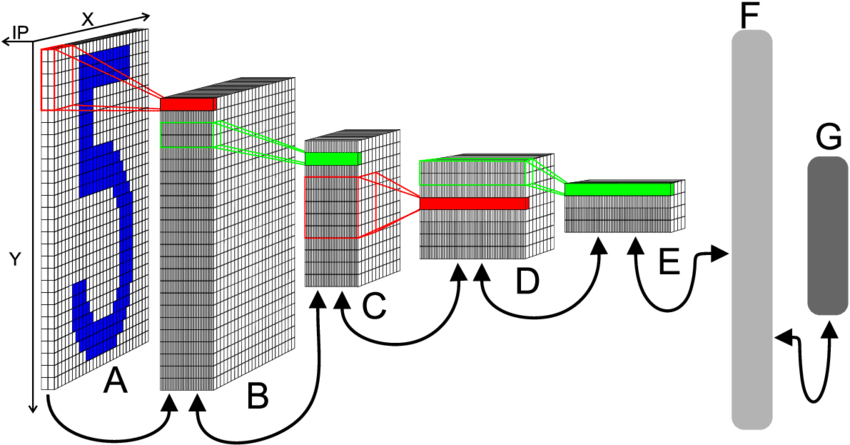

# MNIST Classification using CNN with Data Augmentation

In this notebook, we aim to classify handwritten digits from the MNIST dataset using a Convolutional Neural Network (CNN). We will also apply data augmentation techniques to improve generalization and accuracy. The goal is to achieve a high accuracy on the test dataset.

---

# Notebook Guidelines

This notebook is structured to walk you through the process of building, training, and evaluating a Convolutional Neural Network (CNN) on the MNIST dataset. Here's what you can expect in each section:

1. **[Introduction](#Introduction):** 
   - Overview of the MNIST dataset and the objective of this notebook.
   
2. **[Loading and Preprocessing the Data](#Loading-and-Preprocessing-the-Data):**
   - Steps to load the dataset, preprocess it (such as reshaping and normalization), and split it into training, validation, and test sets.
   
3. **[Building the CNN Model](#Building-the-CNN-Model):**
   - Explanation of the CNN architecture used for this task, including details on convolutional layers, pooling layers, batch normalization, and dropout.

4. **[Training the Model](#Training-the-Model):**
   - Training the model on the training dataset and using validation data to monitor performance. The model is trained using the Adam optimizer and categorical cross-entropy loss.

5. **[Results and Evaluation](#Results-and-Performance-Visualization):**
   - Evaluate the model’s performance on the test dataset and visualize the accuracy and loss over the training epochs.

6. **[Conclusion](#Conclusion):**
   - Summarize the results and provide insights into potential improvements or future work.


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images
import numpy as np

## Loading and Preprocessing the Data

We begin by loading the MNIST dataset, which consists of 60,000 training images and 10,000 test images. Each image is a 28x28 grayscale image, and we will preprocess the data by reshaping it and splitting it into training, validation, and test sets.

---

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = mnist = tf.keras.datasets.mnist.load_data()

X_train,X_valid = X_train_full[:45000],X_train_full[45000:]
y_train,y_valid = y_train_full[:45000],y_train_full[45000:]


X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

assert X_train.shape == (45000, 28, 28,1)
assert X_test.shape == (10000, 28, 28,1)
assert y_train.shape == (45000,)
assert y_test.shape == (10000,)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(y_train),seed=42).batch(32).prefetch(1)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid,y_valid)).batch(32).prefetch(1)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(32).prefetch(1)

## Data Augmentation

In [4]:
aug_layers = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.05,input_shape=X_train.shape[1:]),                         
    tf.keras.layers.RandomZoom(height_factor=(-0.1, 0),width_factor=(-0.1, 0)),         
    tf.keras.layers.RandomContrast(factor=0.1),                  
    tf.keras.layers.RandomTranslation(height_factor=0.01, width_factor=0.01),       
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


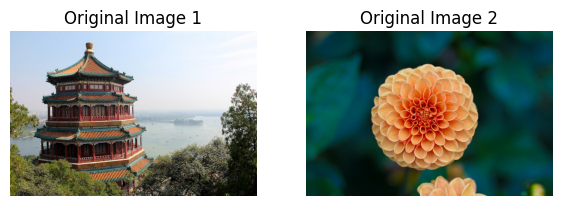



Epoch: 1




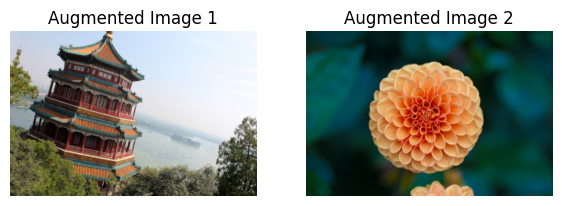



Epoch: 2




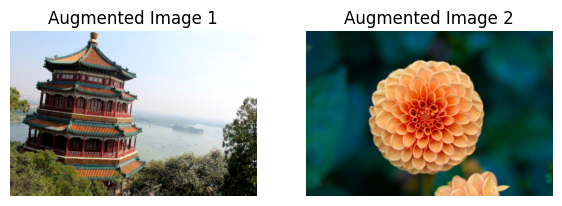



Epoch: 3




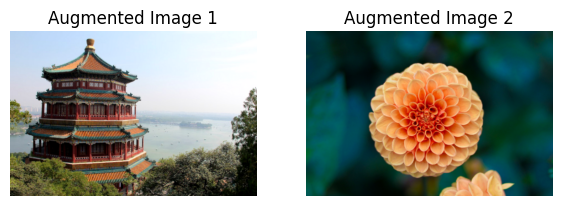

In [5]:
sample = load_sample_images()  
images = np.array(sample.images, dtype=np.float32)

# Function to apply augmentation to a batch of images
def augment_images(images, augment_layer):
    img_batch = tf.convert_to_tensor(images)
    augmented_images_batch = augment_layer(img_batch)
    return augmented_images_batch.numpy()

# Function to plot images
def plot_images(images, titles, fig_size=(7, 4)):
    plt.figure(figsize=fig_size)
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img / 255.0)  
        plt.title(title)
        plt.axis('off')
    plt.show()

# Main function to visualize original images and augmented images over multiple epochs
def visualize_images(images, augment_layer, epochs=3):
    # Visualize original images only once
    plot_images(images, [f"Original Image {i+1}" for i in range(len(images))])

    for epoch in range(1, epochs + 1):
        print(f"\n\nEpoch: {epoch}\n\n")
        augmented_images = augment_images(images, augment_layer)
        plot_images(augmented_images, [f"Augmented Image {i+1}" for i in range(len(images))])

visualize_images(images, aug_layers, epochs=3)

## Building the CNN Model

The CNN architecture includes multiple convolutional layers followed by max-pooling and fully connected layers. We will use batch normalization and dropout to prevent overfitting. The model will be trained using the Adam optimizer and categorical cross-entropy loss.

---

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [7]:
num_classes=10

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1./255, input_shape=X_train.shape[1:]),
    aug_layers,
    tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='leaky_relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='leaky_relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', activation='leaky_relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),  # Add Dropout
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,962 (367.04 KB)

 Trainable params: 93,962 (367.04 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy',optimizer=optim,metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=6,         
    restore_best_weights=True  
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',  
    monitor='val_loss',         
    save_best_only=True,       
    mode='min',                
    verbose=1                  
)

## Training the Model

We will train the CNN on the training set for 30 epochs, and monitor the performance on the validation set. Early stopping will be used to prevent overfitting.


------

.


In [10]:
history= model.fit(train_dataset, validation_data=valid_dataset, epochs=30, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6601 - loss: 0.9960
Epoch 1: val_loss improved from inf to 0.11184, saving model to best_model.keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.6602 - loss: 0.9957 - val_accuracy: 0.9648 - val_loss: 0.1118
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9408 - loss: 0.2000
Epoch 2: val_loss improved from 0.11184 to 0.08705, saving model to best_model.keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9408 - loss: 0.2000 - val_accuracy: 0.9705 - val_loss: 0.0871
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9544 - loss: 0.1475
Epoch 3: val_loss improved from 0.08705 to 0.06755, saving model to best_model.keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9544 - loss: 0.1475 - val_accuracy: 0.9797 - val_loss: 0.0675
Epoch 4/30
1401/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9621 - loss: 0.1270
Epoch 4: val_loss improved from 0.06755

In [11]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9909 - loss: 0.0251
Test accuracy: 0.9930


## Results and Performance Visualization

After training, we will evaluate the model on the test dataset and plot the training/validation accuracy and loss over epochs to visualize the model's performance.

--- 
.


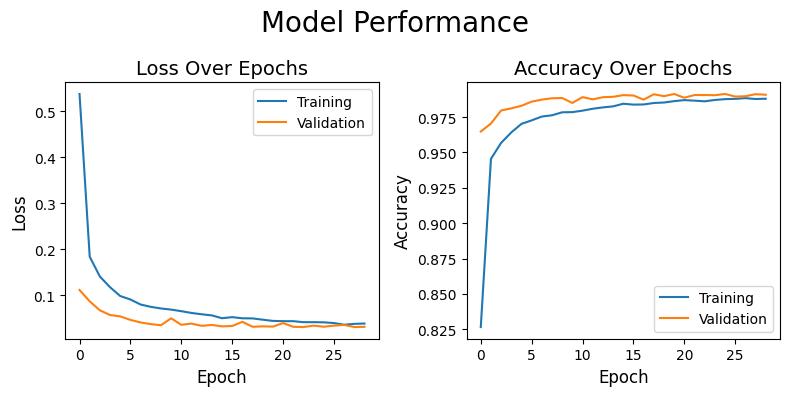

In [12]:
history_dict = history.history
metrics_to_plot = {
    'Loss': ('loss', 'val_loss'),
    'Accuracy': ('accuracy', 'val_accuracy'),
}

fig = plt.figure(figsize=(8, 4))

for i, (metric_name, (train_metric, val_metric)) in enumerate(metrics_to_plot.items(), 1):
    plt.subplot(1, 2, i)
    plt.plot(history_dict[train_metric], label='Training')
    plt.plot(history_dict[val_metric], label='Validation')
    plt.title(f'{metric_name} Over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.legend()

fig.suptitle('Model Performance',size=20)
fig.tight_layout()
plt.show()

## Conclusion

In this notebook, we successfully built and trained a CNN to classify handwritten digits from the MNIST dataset. By applying data augmentation and regularization techniques, we achieved a test accuracy  99.24%. Further improvements can be made by tuning the hyperparameters or using advanced architecture.


---